In [1]:
from self_supervised.pipelines.representation_model import RepresentationModel, YoloEncoder
from yolov5.models.yolo import DetectionModel
import torch

%reload_kedro
model_description = catalog.load("yolov5_l_description")
trained_model = catalog.load("trained_model", version="2023-03-21T10.06.00.000Z")

# Random model
# encoder = YoloEncoder(model_description=model_description)
# trained_model = RepresentationModel(encoder=encoder)

# CoCO model
# model_description["head"] = model_description["head"][:-1]
# trained_model = DetectionModel(model_description)
# weights_model = torch.load("../yolov5l.pt", map_location="cpu")
# state_dict = weights_model["model"].float().state_dict()
# trained_model.load_state_dict(state_dict, strict=False)

trained_model = trained_model.encoder
trained_model = trained_model.eval()

2023-03-21 10:22:34,857 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/thop/profile.py:12: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(torch.__version__) < LooseVersion("1.0.0"):

2023-03-21 10:22:34,857 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/thop/profile.py:68: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(torch.__version__) >= LooseVersion("1.1.0"):

2023-03-21 10:22:34,974 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":

2023-03-21 10:22:34,975 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/pyth

2023-03-21 10:22:35.213 | WARNING  | self_supervised.extras.datasets.pytorch_model_data_set:_load:42 - CUDA not available, automatically mapping variables to the CPU.


In [4]:
from pathlib import Path

dataset_path = Path("/home/daniel/lab_share/projects/CottonFlower2021/flower_dataset")
image_dir = dataset_path / "active_1" / "images"

In [5]:
# import random
# random.sample(range(160), 10)

# indices = [143, 159, 78, 12, 34, 116, 118, 0, 44, 124]

In [6]:
from torchvision.io import read_image
from torchvision.transforms.functional import resize
from tqdm import tqdm
import torch

image_reps = []

image_list = sorted(list(image_dir.iterdir()))
# image_list = [image_list[i] for i in indices]
for image_path in tqdm(image_list):
    image = read_image(image_path.as_posix())
    image.requires_grad = False
    image = resize(image, (512, 512))
    image = image.to(torch.float) / 255
    image_ex = image[None, :, :, :]
    
    image_reps.append(trained_model(image_ex)[0].detach().reshape((1, -1)).numpy())

100%|████████████████████████████████████████████████████| 160/160 [00:24<00:00,  6.63it/s]


In [7]:
# Load flower counts.
import pandas as pd

labels_dir = dataset_path / "active_1" / "labels"
all_labels = []
labels_list = sorted(list(labels_dir.iterdir()))
# labels_list = [labels_list[i] for i in indices]
for labels_path in labels_list:
    frame_labels = pd.read_csv(labels_path, sep=" ", names=["class", "x", "y", "width", "height"])
    frame_labels["frame"] = labels_path.name
    all_labels.append(frame_labels)
    
all_labels = pd.concat(all_labels, ignore_index=True)
all_labels

,class,x,y,width,height,frame
0,0,0.386324,0.308469,0.030488,0.046636,p0_P1090018.txt
1,0,0.284843,0.252320,0.026132,0.038283,p0_P1090081.txt
2,0,0.448606,0.327726,0.013937,0.029002,p0_P1090300.txt
3,0,0.138937,0.221578,0.023519,0.032483,p0_P1090300.txt
4,0,0.030488,0.099768,0.024390,0.034803,p0_P1090300.txt
...,...,...,...,...,...,...
300,0,0.309612,0.294762,0.010253,0.014188,p9_P1680757.txt
301,0,0.365584,0.297645,0.009460,0.017842,p9_P1680757.txt
302,0,0.500000,0.379350,0.013937,0.016241,p9_P1680757.txt
303,0,0.908537,0.736079,0.012195,0.017401,p9_P1680757.txt


In [8]:
import numpy as np

# Create flower counts labels.
flower_counts = []
for image_path in labels_list:
    flower_counts.append(np.count_nonzero(all_labels["frame"] == image_path.name))
    
# Any missing counts are zeros.
for _ in range(len(flower_counts), len(image_reps)):
    flower_counts.append(0)

In [9]:
test_image_dir = dataset_path / "2018-08-22" / "images"

test_image_reps = []

image_list = sorted(list(test_image_dir.iterdir()))
for image_path in tqdm(image_list):
    image = read_image(image_path.as_posix())
    image.requires_grad = False
    image = resize(image, (512, 512))
    image = image.to(torch.float) / 255
    image_ex = image[None, :, :, :]
    
    test_image_reps.append(trained_model(image_ex)[0].detach().reshape((1, -1)).numpy())

100%|████████████████████████████████████████████████████| 160/160 [00:25<00:00,  6.33it/s]


In [10]:
test_labels_dir = dataset_path / "2018-08-22" / "labels"
all_labels_test = []
labels_list = sorted(list(test_labels_dir.iterdir()))
for labels_path in labels_list:
    frame_labels = pd.read_csv(labels_path, sep=" ", names=["class", "x", "y", "width", "height"])
    frame_labels["frame"] = labels_path.name
    all_labels_test.append(frame_labels)
    
all_labels_test = pd.concat(all_labels_test, ignore_index=True)
all_labels_test

,class,x,y,width,height,frame
0,0,0.414497,0.818287,0.039062,0.046296,p0_P2530585.txt
1,0,0.245660,0.649884,0.019097,0.028935,p0_P2530668.txt
2,0,0.636719,0.209491,0.018229,0.025463,p0_P2530668.txt
3,0,0.827691,0.566551,0.019965,0.026620,p0_P2530668.txt
4,0,0.392734,0.709734,0.022448,0.033588,p0_P2530668.txt
...,...,...,...,...,...,...
382,0,0.053385,0.823495,0.021701,0.028935,p9_P2540369.txt
383,0,0.441840,0.266204,0.019097,0.025463,p9_P2540369.txt
384,0,0.533854,0.799769,0.032986,0.041667,p9_P2540420.txt
385,0,0.404948,0.767361,0.019965,0.025463,p9_P2540420.txt


In [11]:
# Create flower counts.
test_flower_counts = []
for image_path in labels_list:
    test_flower_counts.append(np.count_nonzero(all_labels_test["frame"] == image_path.name))
    
# Any missing counts are zeros.
for _ in range(len(test_flower_counts), len(test_image_reps)):
    test_flower_counts.append(0)

In [12]:
from sklearn.model_selection import PredefinedSplit

# Create combined dataset.
all_image_reps = image_reps + test_image_reps
all_flower_counts = flower_counts + test_flower_counts
train_indices = [-1] * len(image_reps)
test_indices = [0] * len(test_image_reps)
split = PredefinedSplit(train_indices + test_indices)

In [13]:
from sklearn.linear_model import RidgeCV, Ridge

all_flower_counts = np.array(all_flower_counts, dtype=float)
all_image_reps_arr = np.concatenate(all_image_reps, axis=0)

alphas = [1e-6, 1e-4, 0.01, 0.1, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0]
reg_search = RidgeCV(alphas=alphas, cv=split).fit(all_image_reps_arr, all_flower_counts)
# RidgeCV is going to go and refit on the whole dataset once it finds the best alpha, which we don't want.
# Fit manually with the best alpha on just the training data.
reg = Ridge(reg_search.alpha_).fit(np.concatenate(image_reps, axis=0), np.array(flower_counts))

2023-03-21 10:23:44,787 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=6.10134e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)



In [14]:
test_image_reps_arr = np.concatenate(test_image_reps, axis=0)
test_preds = reg.predict(test_image_reps_arr)
test_preds

array([    0.28491,      1.9021,      2.0839,      0.9008,      1.6565,      1.5279,      1.6445,      1.5614,      1.6811,      2.2809,    0.061582,     0.84533,      1.7768,      1.5124,      2.8554,     0.69078,      1.1657,      1.9429,      1.9026,      1.0011,      1.7339,      1.9658,      2.2125,      2.7372,
            2.2213,      1.4645,       1.883,       1.424,       2.033,      1.0651,     0.27459,      1.7655,      2.4646,      2.3028,      4.0761,     0.79255,      1.4088,      2.0491,      1.9222,      2.5441,     0.59771,      1.3189,      4.1298,      2.2416,      2.8411,      3.8799,      1.2145,      1.9339,
            2.8766,      1.0682,     0.88703,      1.1475,      3.7509,      1.9848,      2.4563,      1.4446,      1.4688,      2.7353,      2.2019,     0.43708,     0.76763,      2.4085,      3.4112,      2.3823,      2.2169,       3.392,      1.3955,      1.0435,      1.9578,     0.78807,      1.9106,      2.0723,
            2.3488,      1.8037,      1.8233,      1.7092,      1.9362,      2.7852,      1.1447,     0.87262,     0.87691,       1.717,       2.068,      2.3992,       2.897,      1.4291,      1.8668,     0.89353,      1.4496,      1.3859,     0.71974,      1.5695,      2.0916,      1.1213,      1.9139,      1.7815,
             1.809,      1.9883,     0.64937,      1.1227,      0.6461,      1.9638,      1.4514,     0.20721,      2.5004,      2.5304,      2.2991,      1.7614,      1.8243,      1.6211,   -0.036905,      1.5785,       1.464,      1.6201,      2.2612,     0.93694,      1.3185,     0.13522,      1.2985,      1.9234,
            1.9752,      1.2795,      2.0563,      2.1494,      2.6883,     0.39026,       1.365,      1.7789,      1.8845,       1.486,      1.4403,      2.5191,      3.8557,      2.5494,      1.4234,      1.8495,       1.356,      1.2928,      0.5046,      1.1288,      1.0275,       2.198,      2.4909,      1.1391,
            2.2275,      1.9921,      2.3212,      1.8515,      2.5046,     0.84916,     0.22854,      1.2239,      1.2233,      0.8324,      1.3546,       2.143,      2.5389,      1.4749,     0.93217,      1.4113], dtype=float32)

In [15]:
errors = test_preds - test_flower_counts
np.mean(np.abs(errors))

1.6929579496383667

2023-03-21 10:23:59,717 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":

2023-03-21 10:23:59,717 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)



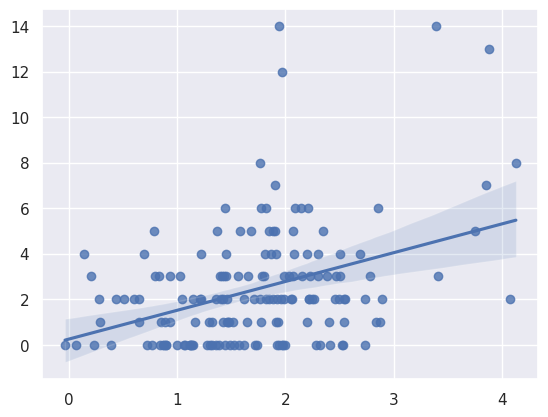

In [16]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

sns.regplot(x=test_preds, y=test_flower_counts)
plt.show()

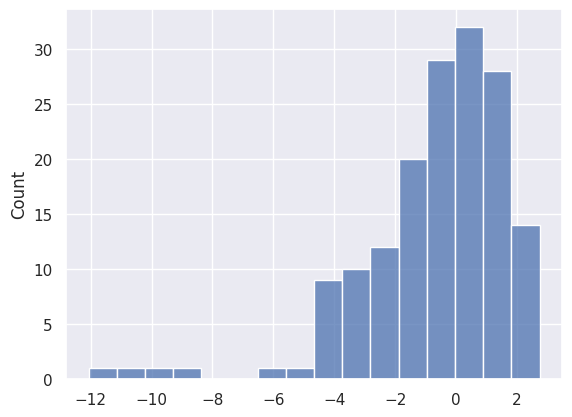

In [17]:
sns.histplot(x=errors)

In [18]:
import numpy as np

# Use the coefficient of variation of the differences between frames to provide a measure of "smoothness".
gt_diff = np.diff(test_flower_counts)
gt_smoothness = np.std(gt_diff) / np.abs(np.mean(gt_diff))
gt_smoothness

301.705982705017

In [19]:
pred_diff = np.diff(test_preds)
pred_smoothness = np.std(pred_diff) / np.abs(np.mean(pred_diff))
pred_smoothness

142.63403

In [20]:
reps_diff = np.diff(test_image_reps_arr, axis=0)
reps_smoothness = np.std(reps_diff, axis=0) / np.abs(np.mean(reps_diff, axis=0))
np.mean(reps_smoothness)

2136.0547